In [89]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit
from lmfit import Model

In [90]:
RUN="14180"
# RUN="13850"


In [91]:
file = f"../data/analysis/Run_{RUN}_Filtered.h5"

# Load the data
data_properties = pd.read_hdf(file, "data_properties")

# Convert 'event' columns to integers
data_properties['event'] = data_properties['event'].astype(int)

# Get event_ids where 'x' or 'y' has NaN values
nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

# Filter out rows in data and data_properties based on the 'event' column
data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]

# Check if there are still NaN values
print(data_properties.isna().sum())

display(data_properties)
print(len(data_properties.event.unique()))

event          0
S2_area        0
cath_area      0
ts_raw         0
deltaT         0
sigma          0
S2_amp         0
x              0
y              0
grass_peaks    0
nS1            0
ts             0
dtype: int64


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454
...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,4.712700e+08,8.121690e+05,1.723014e+09,20.125,2.259608,1.774150e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263
77,16989,4.910421e+08,9.090475e+05,1.723014e+09,383.925,4.716690,1.002240e+06,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857
78,16996,6.697731e+08,1.614886e+06,1.723014e+09,-999.000,6.487710,1.028014e+06,-281.475,14.175,1.0,3.0,2024-08-07 02:03:22.292
79,17003,5.637547e+08,1.186365e+06,1.723014e+09,802.300,6.657705,8.798408e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531


51659


In [92]:
# Rebin the x and y

# Define bin edges using np.linspace for x and y
x_bins = np.linspace(-500, 500, 10)  # 10 evenly spaced bins between -500 and 500
y_bins = np.linspace(-500, 500, 10)

# Bin the x and y columns
data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

# Calculate bin centers
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

print(data_properties['x_bin'].unique())
print(len(data_properties['x_bin'].unique()))

# Assign the bin centers as new columns
data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

# Assign a unique bin ID for each (x_bin, y_bin) pair
data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

display(data_properties)

[5 2 4 3 8 1 6 0 7]
9


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076,5,1,111.111111,-333.333333,5_1
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614,2,5,-222.222222,111.111111,2_5
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943,4,3,0.000000,-111.111111,4_3
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134,3,4,-111.111111,0.000000,3_4
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454,4,1,0.000000,-333.333333,4_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,4.712700e+08,8.121690e+05,1.723014e+09,20.125,2.259608,1.774150e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263,4,1,0.000000,-333.333333,4_1
77,16989,4.910421e+08,9.090475e+05,1.723014e+09,383.925,4.716690,1.002240e+06,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857,4,2,0.000000,-222.222222,4_2
78,16996,6.697731e+08,1.614886e+06,1.723014e+09,-999.000,6.487710,1.028014e+06,-281.475,14.175,1.0,3.0,2024-08-07 02:03:22.292,1,4,-333.333333,0.000000,1_4
79,17003,5.637547e+08,1.186365e+06,1.723014e+09,802.300,6.657705,8.798408e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531,2,6,-222.222222,222.222222,2_6


In [93]:
print(len(nan_event_ids))

430


Text(0.5, 1.0, 'RUN 14180')

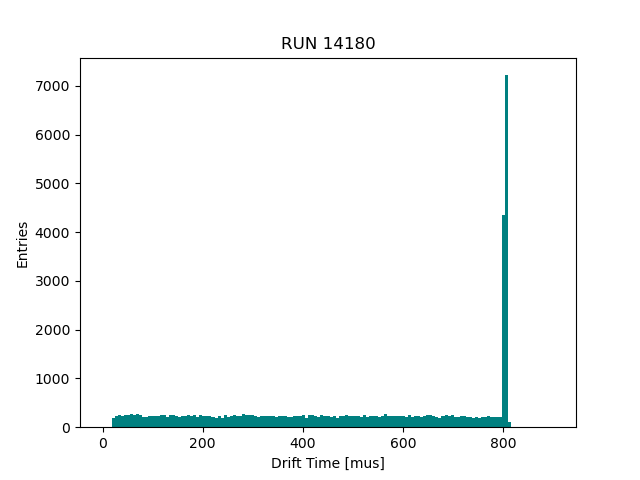

In [94]:
%matplotlib widget
plt.figure()

plt.hist(data_properties.deltaT, bins = np.linspace(0, 900, 150), color = "Teal");
plt.xlabel("Drift Time [mus]")
plt.ylabel("Entries")
plt.title(f"RUN {RUN}")


False


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/684025163.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


Text(0, 0.5, 'Y [mm]')

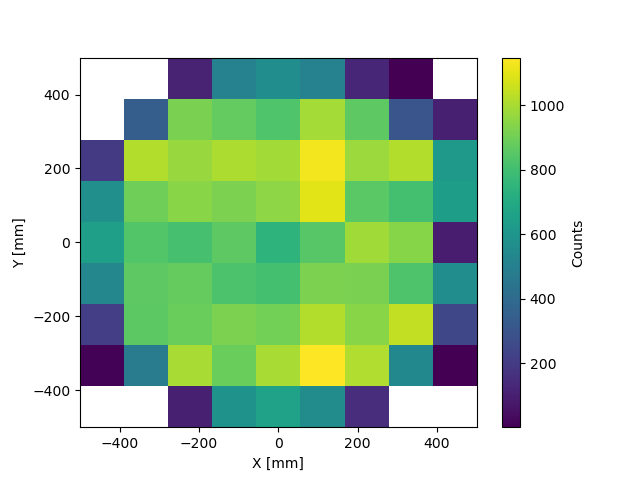

In [95]:
%matplotlib widget
fig, ax = plt.subplots()
has_nan = data_properties['x'].isna().any()
print(has_nan)

hist, xedges, yedges = np.histogram2d(data_properties.x, data_properties.y, bins=[np.linspace(-500,500,10),np.linspace(-500,500,10)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



In [96]:
data_properties_active = data_properties[ (data_properties.deltaT > 0) & (data_properties.deltaT < 795)]

5.202384425809112 36.62335445605632


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


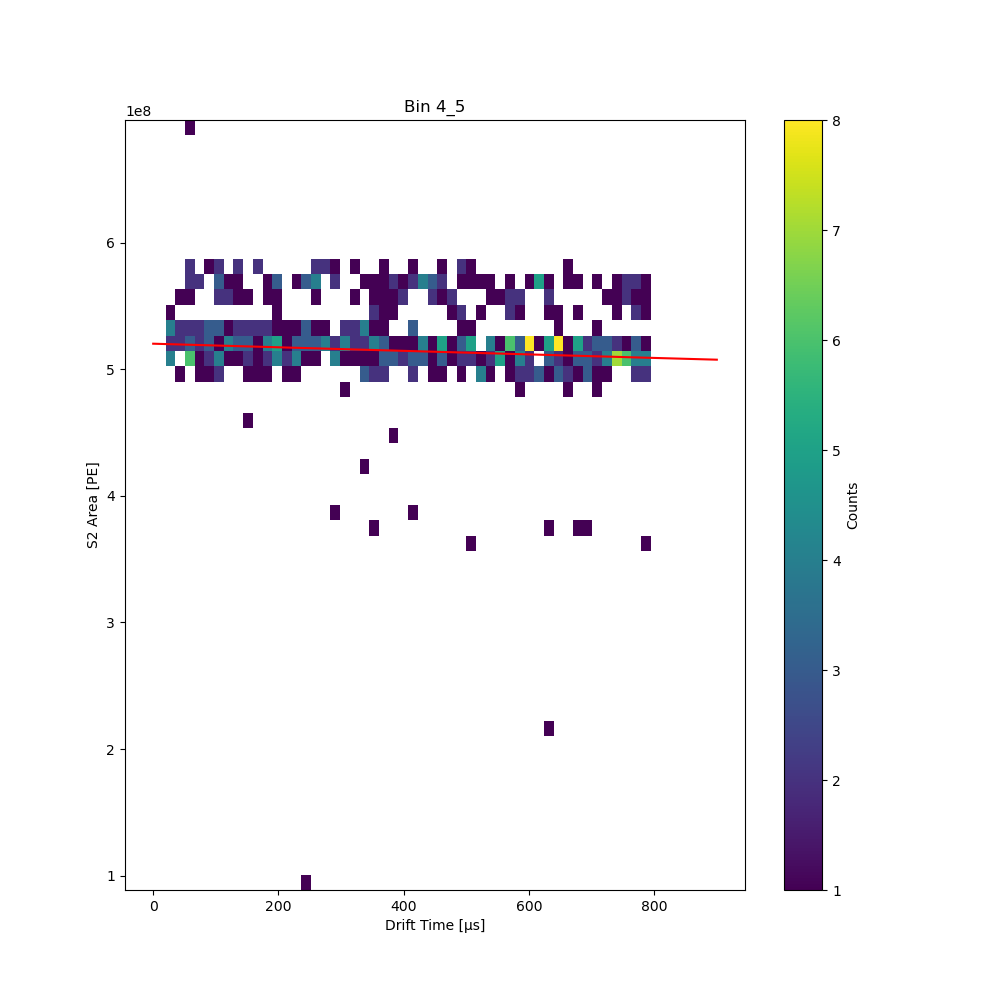

In [97]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts


    lower_bound = max_bin_value-0.5e8 + 0.05e8
    upper_bound = max_bin_value+0.25e8 + 0.05e8

    df_bin = df_bin[ (df_bin.S2_area > -1e4*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -1e4*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 20):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)

    t = np.linspace(0,800,300)
    # plt.plot(df_bin['deltaT'], -1e4*df_bin.deltaT+upper_bound) # if you want to plot the bands plot this. 
    # plt.plot(df_bin['deltaT'], -1e4*df_bin.deltaT+lower_bound)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, bounds = ([1e8, 1e3], [8.5e8, 100e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    print(q_fit/1e8, tau_fit/1e3 )

    return q_fit, tau_fit


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Filter data based on the current bin_id
bin_ = "2_5"
df_bin = data_properties_active[data_properties_active.bin_id == bin_] # 4_5, 

# Create 2D histogram
hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=50)

# Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# Custom colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# Plot with pcolormesh
pcm = ax.pcolormesh(x_edges, y_edges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

# Set labels
ax.set_xlabel("Drift Time [μs]")
ax.set_ylabel("S2 Area [PE]")
ax.set_title(f"Bin 4_5")
# ax.set_ylim(2.5e8,4.5e8)

# # Generate fitted curve
t_fit = np.linspace(0, 900, 100)

q_fit, tau_fit = FitLifetime(data_properties_active, bin_)
hist_fit = exp_decay(t_fit, q_fit, tau_fit)

# # Plotting the fitted exponential decay curve
ax.plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/2585041145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/2585041145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: div

4.7022452935833705 17.925674864639973
4.3892086282469815 24.881303512762504
4.0867045105575395 99.99999999997233
3.935113631493469 17.48525089785112
4.622359179443895 55.212427430298575


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)


4.997531294311643 99.99999999999994
5.102821191343477 43.09546260253614
4.918894083094195 50.022251015446244
4.770880080625519 27.73611048827854
4.432501832837893 99.99999999968115
4.183825187963792 99.99999993337514
3.9692388588916403 87.49371021656225
4.006956399237753 15.70219850266337
4.8365221856149505 31.540586866639348
5.172517562178933 50.609834330074584
5.304690353807948 35.611480828084154
5.122183372097979 82.89946278914432
5.063830298043122 53.83417066312467
4.801018629745232 99.99999999887035
4.4163325558640665 99.99999999999997
4.134063148117656 99.99999999997874
4.127949769374925 40.30317437180134
4.812281245433303 43.40235215239676
5.202384425809112 36.62335445605632
5.256329351597507 45.649105218655286
5.270282710804725 45.085917320233506
5.169536948647312 43.0677535266473
5.002039417804431 44.15054089498049
4.745915550199677 99.99999999999997
4.26930446147332 99.9999999944566
4.069342496115657 99.99999999999986
4.798477375267098 38.504995038108305
5.034584257099145 68.

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)


3.551189688083427 77.51532977395769
3.9806956568005605 43.28060833425003
4.180044899765391 99.99999999999999
4.601487750996356 86.57882968129506
4.973119949668949 55.844142843647155
5.251195366488651 38.55693319455104
5.103186081269166 99.99999999999999
3.035094363455714 12.137004040525445


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * 

5.444950409751272 24.860870871674887
5.471415056177018 28.154795809951125
4.373000924881635 99.99999999999055
4.374866510636677 11.860313490985215


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/1331592826.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)


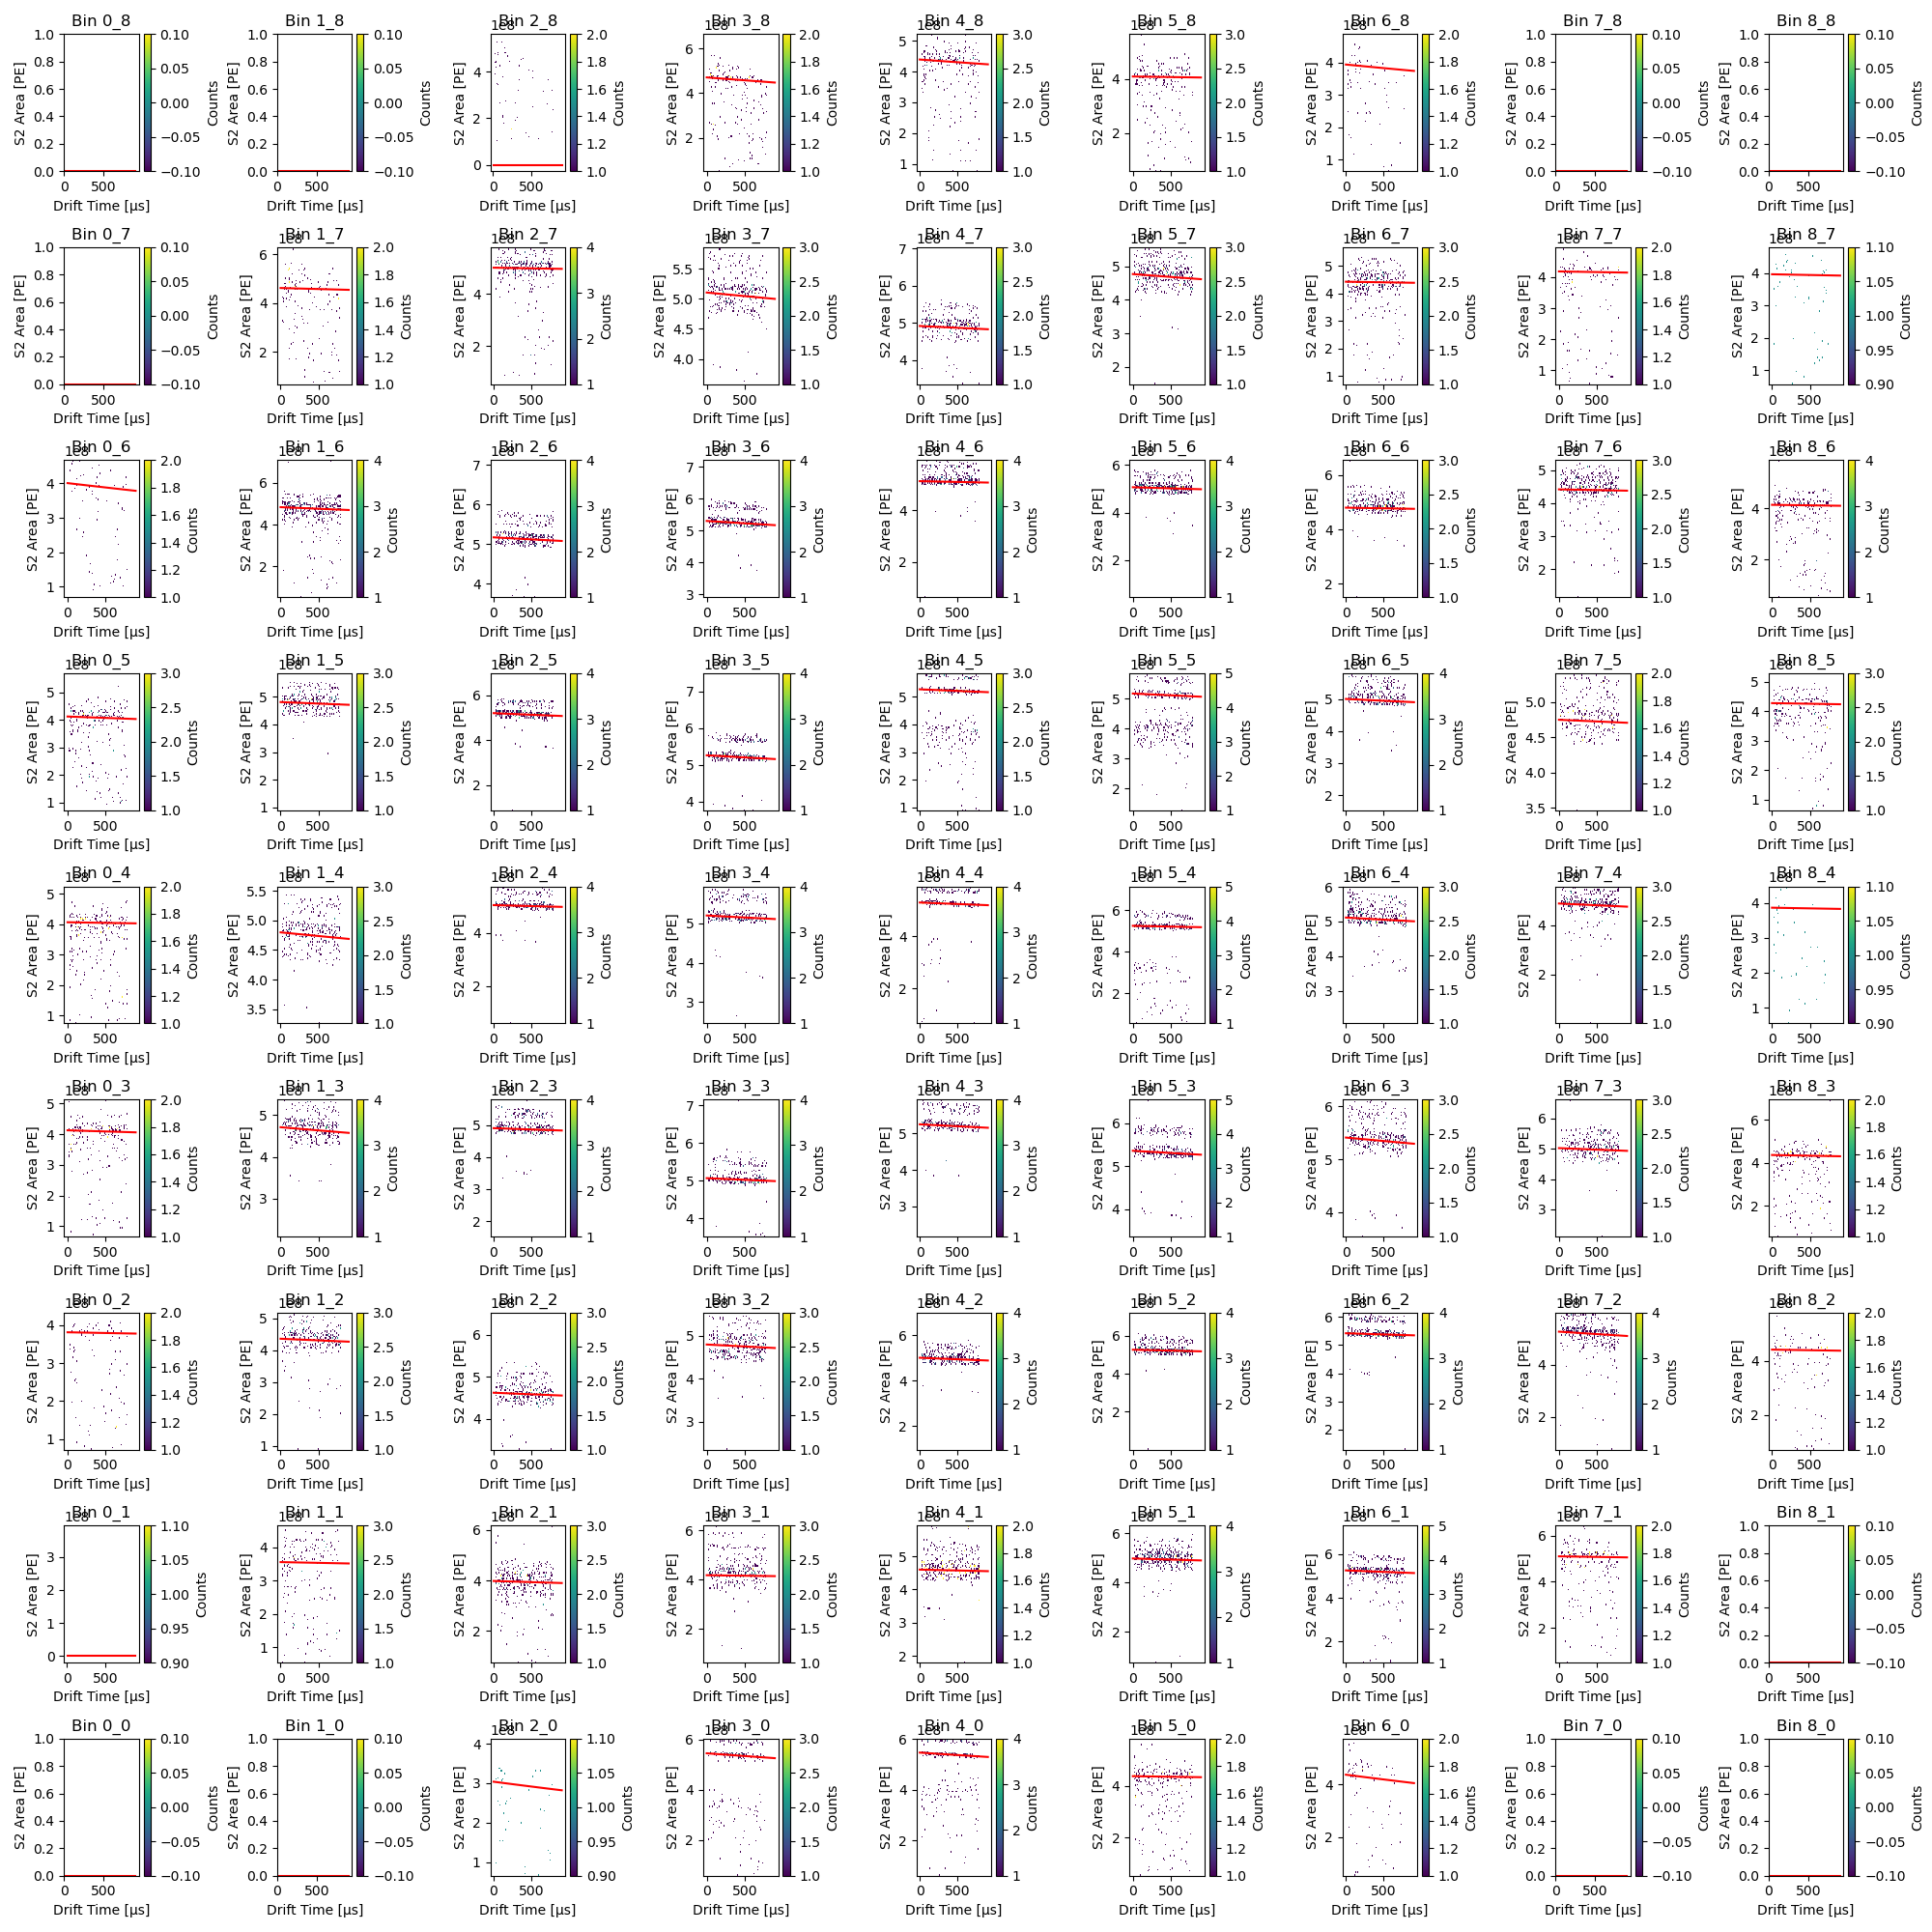

/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['bin_id', 'lt', 'q0'], dtype='object')]

  pytables.to_hdf(


In [98]:
# Make a plot of the time vs peak width

data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)
data_properties_active = data_properties_active[data_properties_active.S2_amp > 0]

data_properties['sigma'] = data_properties['sigma'].fillna(0)
data_properties['S2_amp'] = data_properties['S2_amp'].fillna(-1)
data_properties = data_properties[data_properties.S2_amp > 0]


# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("S2 Area [PE]")
    ax.set_title(f"Bin {bin_id}")
    # ax.set_ylim(2.5e8,4.5e8)


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(8, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        
        plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

        t_fit = np.linspace(0, 900, 100)

        q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
        hist_fit = exp_decay(t_fit, q_fit, tau_fit)

        # # Plotting the fitted exponential decay curve
        axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

        # Create a new DataFrame to append
        new_data = pd.DataFrame({
            "bin_id": [f"{x}_{y}"],
            "lt": [tau_fit],
            "q0": [q_fit]
        })

        lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# Save the calibration map
lifetime_df.to_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", key='map', mode='w')


,bin_id,lt,q0
0,0_8,0,0
1,1_8,0,0
2,2_8,0,0
3,3_8,17925.674865,470224529.358337
4,4_8,24881.303513,438920862.824698
...,...,...,...
76,4_0,28154.79581,547141505.617702
77,5_0,100000.0,437300092.488163
78,6_0,11860.313491,437486651.063668
79,7_0,0,0


Text(0.5, 1.0, 'Q0')

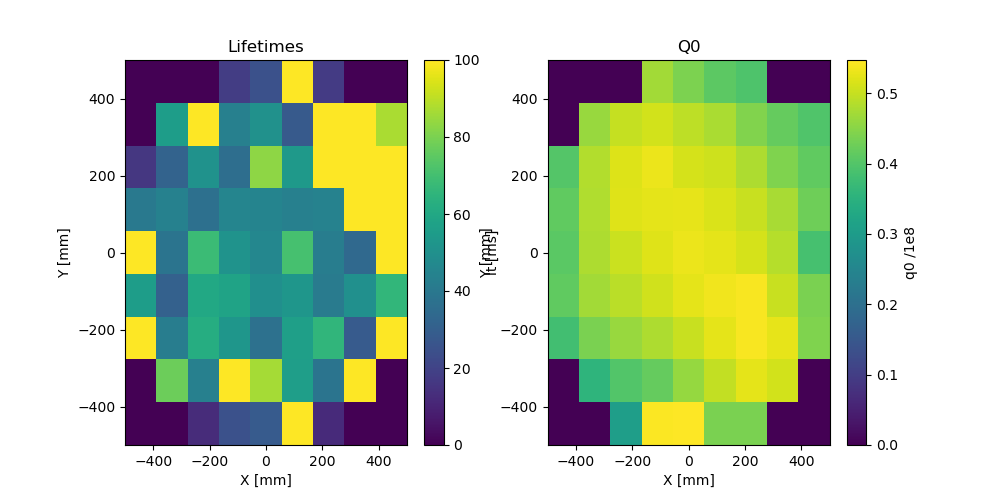

In [99]:
%matplotlib widget

display(lifetime_df)

# Function to extract x and y positions from bin_id
def get_bin_position_from_id(bin_id, x_bin_centers, y_bin_centers):
    try:
        x_bin, y_bin = map(int, bin_id.split('_'))  # Split and convert bin_id to integers
        return x_bin_centers[x_bin], y_bin_centers[y_bin]
    except (ValueError, IndexError) as e:
        return np.nan, np.nan  # Return NaN if there's an issue with the bin_id

# Apply the function to create new columns
lifetime_df_pos= lifetime_df
lifetime_df_pos[['x_center', 'y_center']] = lifetime_df['bin_id'].apply(
    lambda bid: pd.Series(get_bin_position_from_id(bid, x_bin_centers, -1*y_bin_centers))
)


# Create pivot table to reshape the data for 2D plotting
lt_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='lt')

# Sort the axes (necessary if bin centers are not in order)
lt_pivot = lt_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
lt_pivot = lt_pivot.astype(float).fillna(0) 

# Create pivot table to reshape the data for 2D plotting
q0_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='q0')

# Sort the axes (necessary if bin centers are not in order)
q0_pivot = q0_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
q0_pivot = q0_pivot.astype(float).fillna(0) 


# Plotting using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the pcolormesh plot
c = axs[0].pcolormesh(x_bins, y_bins, lt_pivot / 1e3, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[0], label='lt [ms]')  # Specify 'ax' to link the color bar to the plot
axs[0].set_xlabel('X [mm]')
axs[0].set_ylabel('Y [mm]')
axs[0].set_title('Lifetimes')


c = axs[1].pcolormesh(x_bins, y_bins, q0_pivot / 1e9, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[1], label='q0 /1e8')  # Specify 'ax' to link the color bar to the plot
axs[1].set_xlabel('X [mm]')
axs[1].set_ylabel('Y [mm]')
axs[1].set_title('Q0')


In [100]:
# Plot the alpha map of

def CorrectLifetime(row, var, q0_max):

    lt = row["lt"]
    time = row["deltaT"]
    q0 = row["q0"]

    if (q0 == 0):
        q_corr = 1
    else:
        q_corr = q0_max/q0


    if (lt == 0):
        return 1
    else:
        return q_corr * row[var] / np.exp(-1*time/lt)

def CorrectLifetimeAvg(row, var, t, mean_lt):

    time = row[t]

    if (mean_lt == 0):
        return 1
    else:
        return row[var] / np.exp(-1*time/mean_lt)



mean_lt = np.mean(lifetime_df[lifetime_df["lt"] > 0]["lt"])
print("Mean Lifetime is:", mean_lt/1e3, " ms")

data_properties_active_lt = pd.merge(data_properties_active, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_active_lt.q0)
data_properties_active_lt["S2_areaC"] = data_properties_active_lt.apply(lambda row: CorrectLifetime(row, "S2_area", q0_max), axis=1)
data_properties_active_lt["R"] = np.sqrt(data_properties_active_lt["x"]*data_properties_active_lt["x"] + data_properties_active_lt["y"]*data_properties_active_lt["y"])

data_properties_lt = pd.merge(data_properties, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_lt.q0)
data_properties_lt["S2_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetime(row,"S2_area", q0_max), axis=1)
data_properties_lt["R"] = np.sqrt(data_properties_lt["x"]*data_properties_lt["x"] + data_properties_lt["y"]*data_properties_lt["y"])
data_properties_lt["cath_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetimeAvg(row,"cath_area", "deltaT",  mean_lt), axis=1)


nan_event_ids = data_properties_lt[data_properties_lt['R'].isna()]['event'].values
print(nan_event_ids)

display(data_properties_active_lt)


Mean Lifetime is: 58.36605612950451  ms
[]


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,...,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,...,1,111.111111,-333.333333,5_1,55844.142844,497311994.966895,111.111111,333.333333,3.989858e+08,400.217642
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,...,5,-222.222222,111.111111,2_5,36623.354456,520238442.580911,-222.222222,-111.111111,3.986099e+08,230.989126
2,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,...,4,-111.111111,0.000000,3_4,51349.689818,520370265.375599,-111.111111,-0.000000,3.862974e+08,130.939113
3,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,...,1,0.000000,-333.333333,4_1,86578.829681,460148775.099636,0.000000,333.333333,4.388631e+08,326.504221
4,27795,2.479531e+08,6.200161e+05,1.723015e+09,145.900,3.235227,8.012001e+05,412.275,-48.025,0.0,...,4,444.444444,0.000000,8_4,100000.0,386205810.539959,444.444444,-0.000000,3.517905e+08,415.062738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29353,16961,5.416550e+08,1.206564e+06,1.723014e+09,487.125,4.938587,1.035980e+06,10.975,276.025,0.0,...,6,0.000000,222.222222,4_6,82899.462789,512218337.209798,0.000000,-222.222222,5.819949e+08,276.243102
29354,16968,5.846380e+08,1.212443e+06,1.723014e+09,53.525,3.006780,1.741801e+06,196.575,29.225,0.0,...,4,222.222222,0.000000,6_4,42015.951337,511196535.58516,222.222222,-0.000000,6.265447e+08,198.735581
29355,16982,4.712700e+08,8.121690e+05,1.723014e+09,20.125,2.259608,1.774150e+06,26.525,-340.975,1.0,...,1,0.000000,-333.333333,4_1,86578.829681,460148775.099636,0.000000,333.333333,5.604956e+08,342.005155
29356,16989,4.910421e+08,9.090475e+05,1.723014e+09,383.925,4.716690,1.002240e+06,-50.225,-202.025,0.0,...,2,0.000000,-222.222222,4_2,37009.154881,500518563.872697,0.000000,222.222222,5.423797e+08,208.174569


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,...,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R
29,28089,2.165812e+08,6.947361e+05,1.723015e+09,710.025,5.124080,455041.632340,88.725,60.325,1.0,...,5,111.111111,111.111111,5_5,43067.753527,516953694.864731,111.111111,-111.111111,2.330391e+08,107.290406
101,41433,2.434848e+08,6.251884e+05,1.723016e+09,39.150,2.557518,819657.230070,57.625,29.225,0.0,...,4,111.111111,0.000000,5_4,70445.786622,525265551.49058,111.111111,-0.000000,2.537663e+08,64.612238
261,10466,1.015731e+08,2.304659e+05,1.723014e+09,373.925,4.490485,226550.329879,57.625,44.775,0.0,...,4,111.111111,0.000000,5_4,70445.786622,525265551.49058,111.111111,-0.000000,1.063665e+08,72.975621
316,42873,1.970401e+08,4.533462e+05,1.723016e+09,511.950,5.096661,394776.372593,10.975,60.325,0.0,...,5,0.000000,111.111111,4_5,45085.91732,527028271.080473,0.000000,-111.111111,2.068959e+08,61.315220
436,30107,2.170434e+08,8.956592e+06,1.723015e+09,556.825,5.651003,404272.342767,-19.125,-109.725,2.0,...,3,0.000000,-111.111111,4_3,49578.296948,525081307.784897,0.000000,111.111111,2.287164e+08,111.379268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28095,36616,2.037790e+08,5.264323e+05,1.723015e+09,68.950,3.513749,566009.645609,119.825,29.225,0.0,...,4,111.111111,0.000000,5_4,70445.786622,525265551.49058,111.111111,-0.000000,2.124737e+08,123.337469
28156,28861,6.312010e+07,4.358603e+05,1.723015e+09,74.425,1.452718,326928.982910,-50.225,183.725,0.0,...,6,0.000000,222.222222,4_6,82899.462789,512218337.209798,0.000000,-222.222222,6.748420e+07,190.466339
28980,598,6.121495e+07,1.353515e+05,1.723013e+09,710.275,5.750759,115760.838347,57.625,44.775,0.0,...,4,111.111111,0.000000,5_4,70445.786622,525265551.49058,111.111111,-0.000000,6.441056e+07,72.975621
29069,33905,2.936057e+08,5.637989e+05,1.723015e+09,409.875,4.859116,608248.450048,26.525,60.325,0.0,...,5,0.000000,111.111111,4_5,45085.91732,527028271.080473,0.000000,-111.111111,3.075944e+08,65.899023


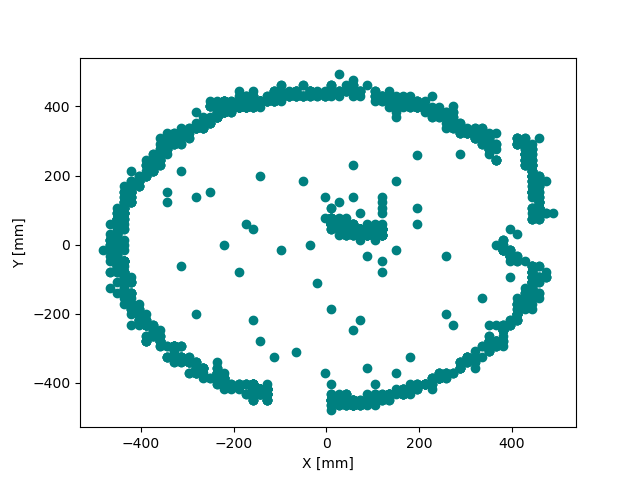

In [101]:
plt.figure()

low_E_S2 = data_properties_active_lt[data_properties_active_lt.S2_areaC < 3.5e8]
plt.scatter(low_E_S2.x, low_E_S2.y, color = "Teal")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")

display(low_E_S2[low_E_S2.R < 200])


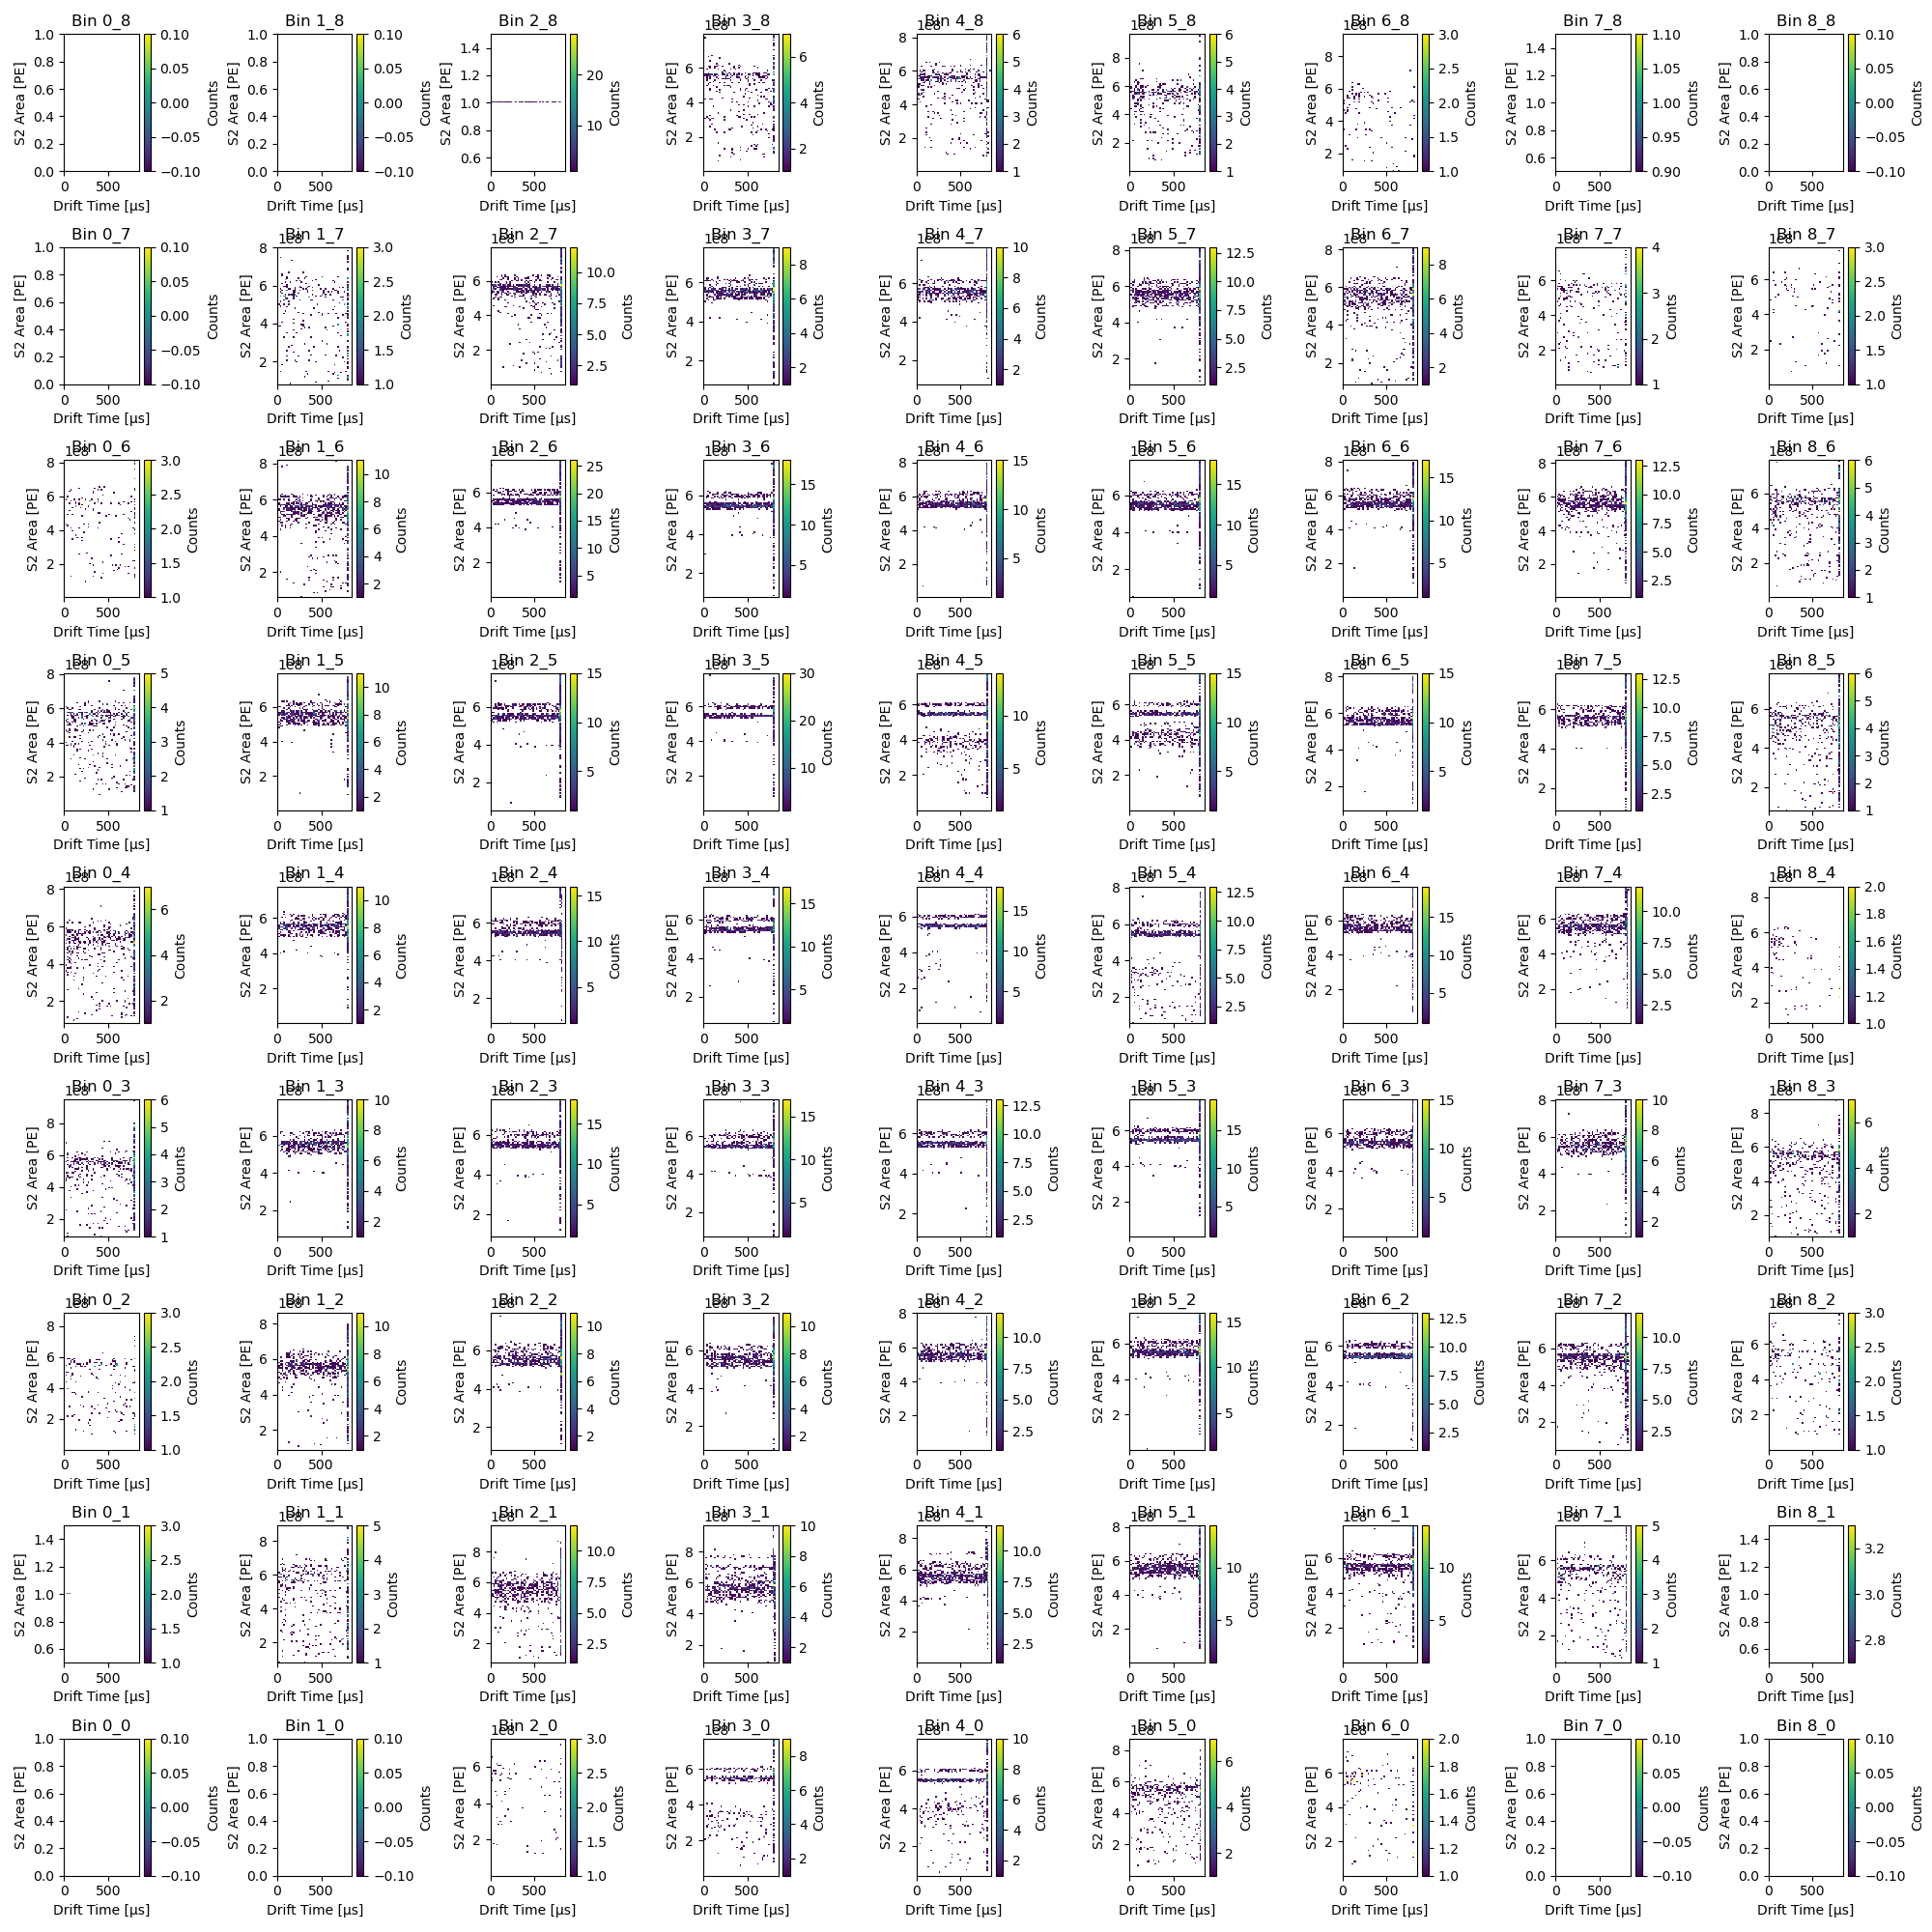

In [102]:
# Create a grid of subplots (5x5)
fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(8, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_lt, "S2_areaC",f"{x}_{y}")   
        axs[counter].set_xlim(0,850)
        # axs[counter].set_ylim(2.5e8,5.5e8)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [103]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# Line
def Line(x, m, c):
    return m*x+c

5.467721434719647
PE conv factor =  1.0241926306706836e-08


Text(761575485.5502366, 175, '7.7 MeV')

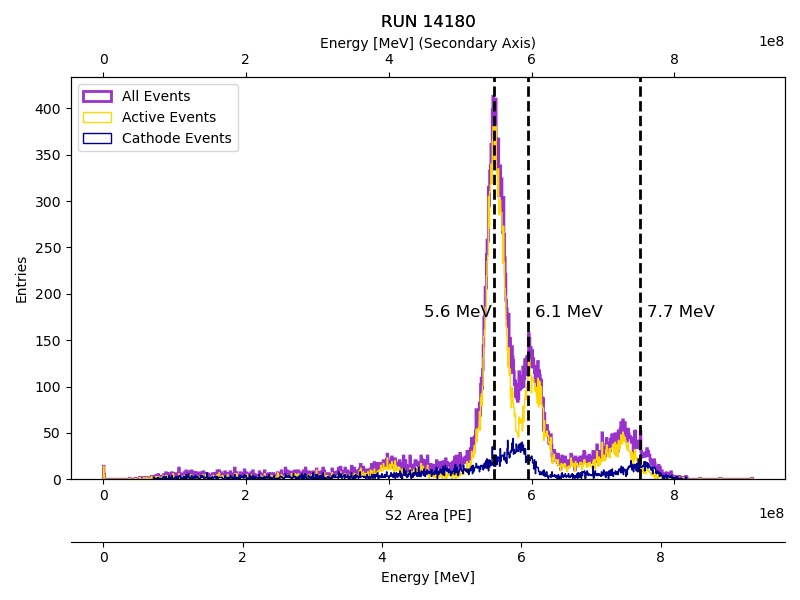

In [104]:
Radial_Cut = 350

# Histogram the S2 energy
fig, ax1 = plt.subplots(figsize = (8,6))

ax1.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
ax1.set_xlabel("S2 Area [PE]")
ax1.set_ylabel("Entries")

# plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
counts, xbins, _ = ax1.hist(data_properties_lt[(data_properties_lt.deltaT<794) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 1000, histtype = "step", label="Active Events", color="gold");
ax1.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
ax1.legend(loc="upper left")


bin_centers = (xbins[:-1] + xbins[1:]) / 2

max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
max_bin_value = xbins[max_bin_index]

print(max_bin_value/1e8)
PE_to_MeV = 5.6/max_bin_value
print("PE conv factor = ", PE_to_MeV)

ax1.set_title(f"RUN {RUN}")

# Create secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlabel("Energy [MeV] (Secondary Axis)")

# Set limits and fewer tick positions for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())


ax2 = ax1.secondary_xaxis("bottom", functions=(lambda x: x * PE_to_MeV, lambda x: x / PE_to_MeV))
ax2.set_xlabel("Energy [MeV]")
ax2.spines['bottom'].set_position(('outward', 45))

fig.tight_layout()

# plt.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
# plt.xlabel("S2 Area [MeV]")
# plt.ylabel("Entries")

# # plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
# counts, xbins, _ = plt.hist(data_properties_lt[(data_properties_lt.deltaT<794)& (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Active Events", color="gold");
# plt.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
# plt.legend(loc="upper left")

ax1.axvline(5.6/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(6.1/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(7.7/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
plt.title(f"RUN {RUN}")

ax1.text(4.6/PE_to_MeV, 175, '5.6 MeV', fontsize=12)
ax1.text(6.2/PE_to_MeV, 175, '6.1 MeV', fontsize=12)
ax1.text(7.8/PE_to_MeV, 175, '7.7 MeV', fontsize=12)

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_82563/2341539982.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


1.5339233962557783 4.377332021555918


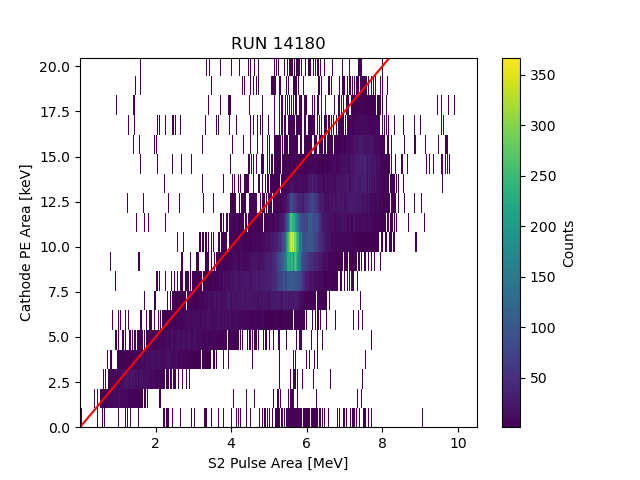

In [105]:
# 1. Create the 2D histogram

data_properties_lt['S2_areaC'] = data_properties_lt['S2_areaC'].fillna(0)
data_properties_lt['cath_areaC'] = data_properties_lt['cath_areaC'].fillna(0)

data_properties_lt_radial = data_properties_lt[data_properties_lt.R < 500]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bins=[500, 1000])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")
# plt.ylim(0,2e6)
plt.ylim(0,2e6*PE_to_MeV*1000)

plt.title(f"RUN {RUN}")

S2_arr = np.linspace(0,10, 100)

# Perform the curve fit
# params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bounds = ([1e8, 1e3], [4.5e8, 100e3]))
params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000)

# Extract the fitted parameters
m, c = params

print(m,c)

plt.plot(S2_arr, Line(S2_arr, 2.5, 0), c = "red")


In [106]:
# Define the plot function
def plot_S2(ax, df, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    ax.hist(df_bin[(df_bin.deltaT<794)].S2_area, bins = 10, histtype = "step", label="Active Events", color="gold");
    ax.hist(df_bin[(df_bin.deltaT>794)].S2_area, bins = 10, histtype = "step", label="Cathode Events", color="DarkBlue");

    # Set labels
    ax.set_xlabel("S2 Area [PE]")
    ax.set_ylabel("Counts")
    ax.set_title(f"Bin {bin_id}")


# # Create a grid of subplots (5x5)
# fig, axs = plt.subplots(10, 10, figsize=(20, 20))  # Adjusted figsize for better spacing
# axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# # Iterate over the unique bin_id values and corresponding subplot axes
# counter = 0
# for y in range(9, -1, -1):
#     for x in range(0, 9, 1):
#         if counter >= len(axs):
#             break  # Avoid indexing beyond available subplots
#         plot_S2(axs[counter], data_properties, f"{x}_{y}")
#         counter=counter+1

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()